In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

In [2]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[int(i)] for i in y if i != padding_index])

In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [4]:
# context initialization
with initialize(config_path="../training/conf/"):
    cfg = compose(config_name="config", overrides=["+experiment=conv_transformer_paragraphs"])

In [5]:
cfg.datamodule.pin_memory = False

In [6]:
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()
print(datamodule)

/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
2021-11-28 19:21:17.994 | INFO     | text_recognizer.data.iam_paragraphs:setup:92 - Loading IAM paragraph regions and lines for None...
2021-11-28 19:21:38.999 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transfor

IAM Original and Synthetic Paragraphs Dataset
Num classes: 58
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 19959, 262, 231
Train Batch x stats: (torch.Size([6, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0103), tensor(0.0588), tensor(1.))
Train Batch y stats: (torch.Size([6, 682]), torch.int64, tensor(1), tensor(57))
Test Batch x stats: (torch.Size([6, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0295), tensor(0.0741), tensor(0.8549))
Test Batch y stats: (torch.Size([6, 682]), torch.int64, tensor(1), tensor(57))



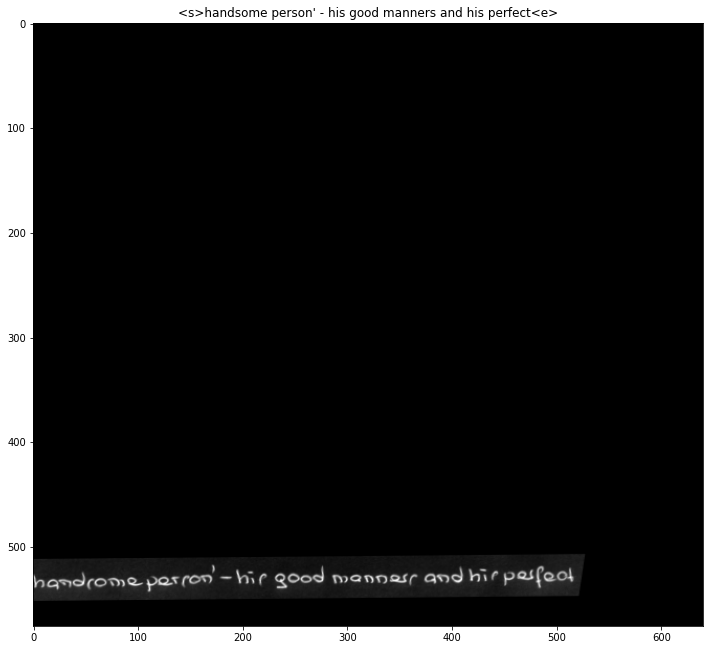

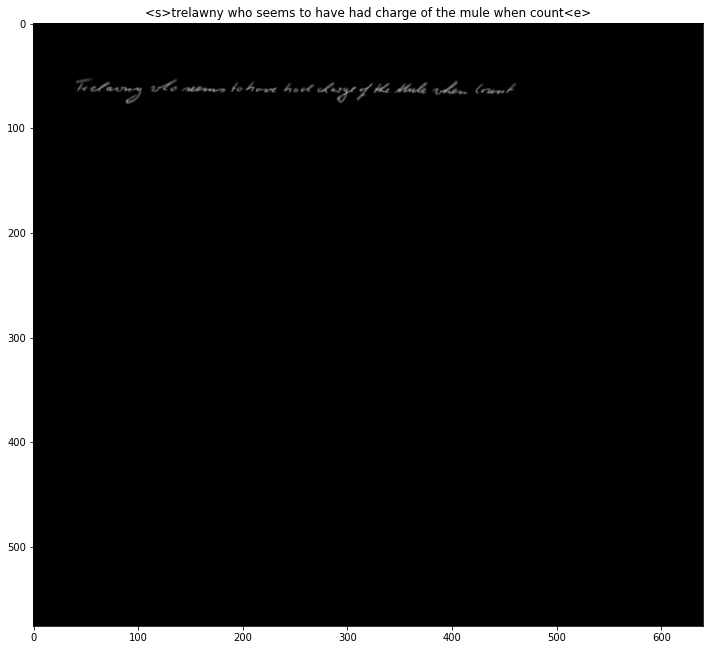

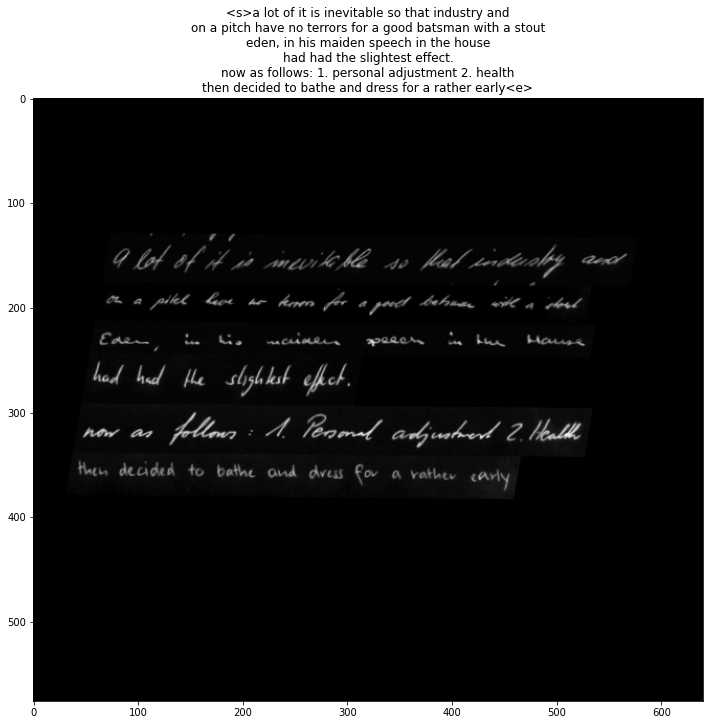

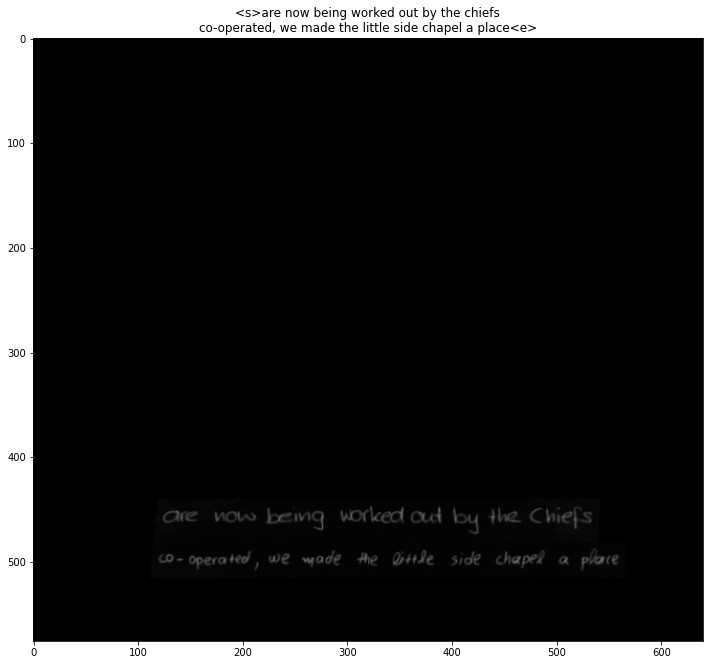

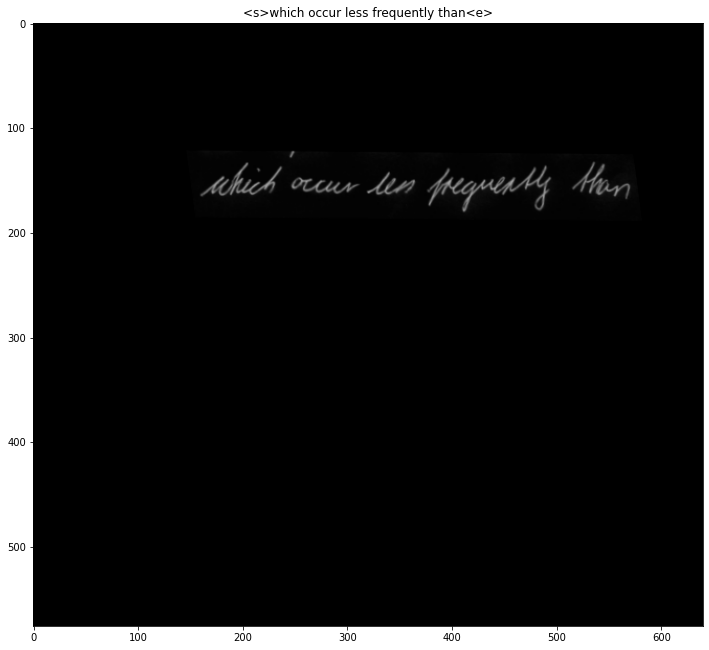

In [7]:
# Training
dataset = datamodule.data_train
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))

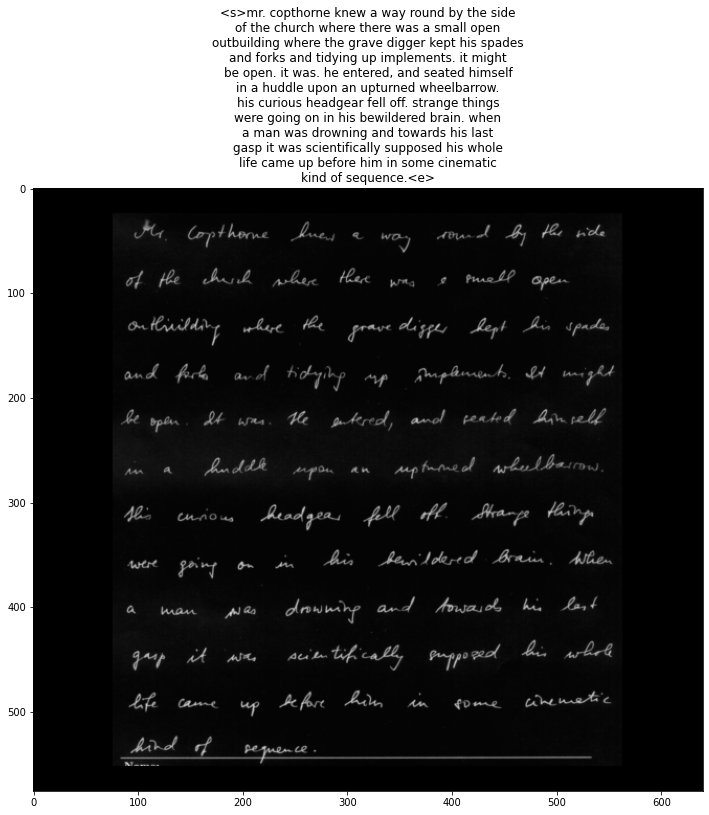

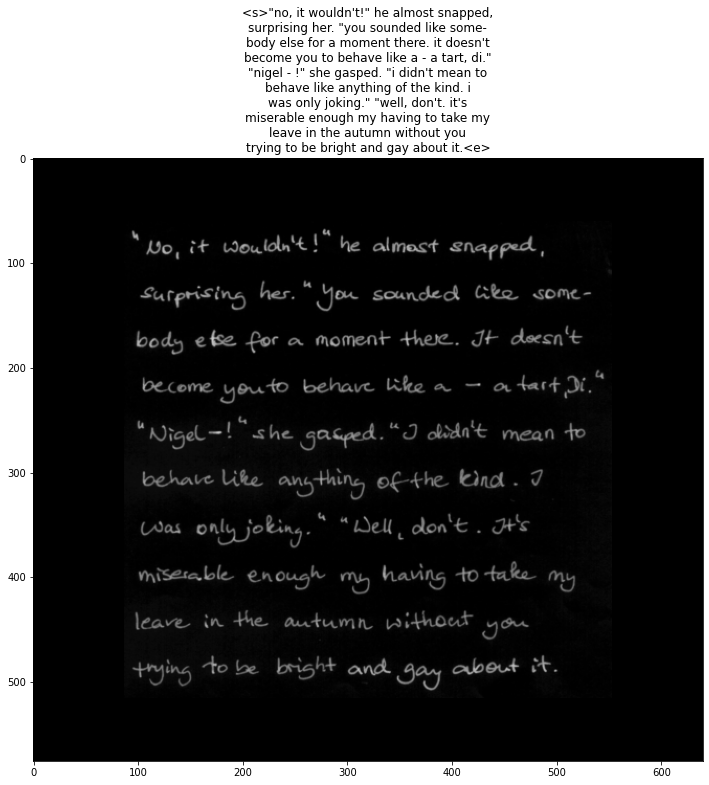

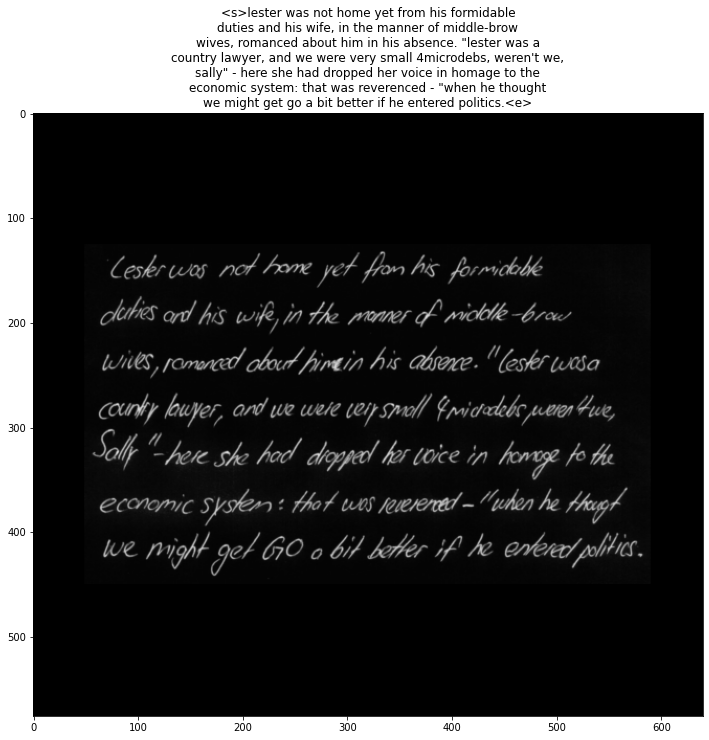

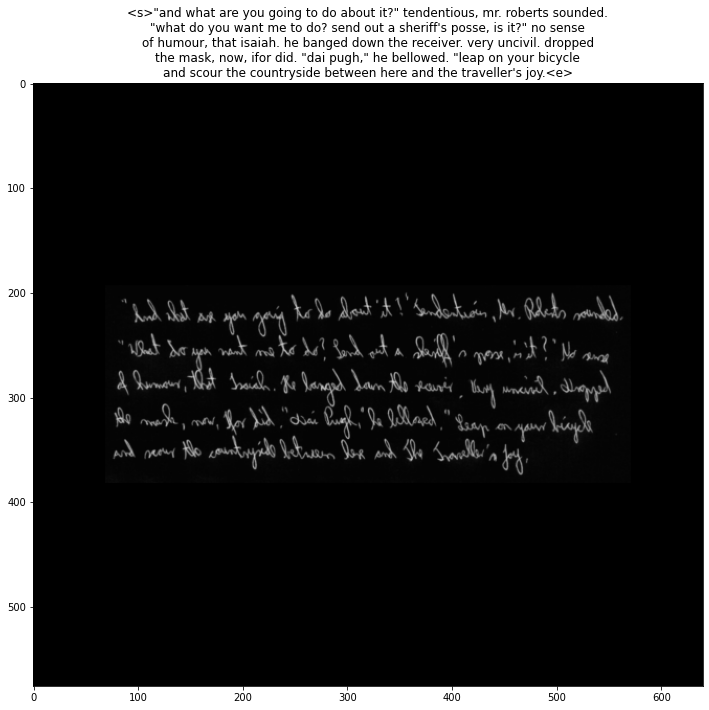

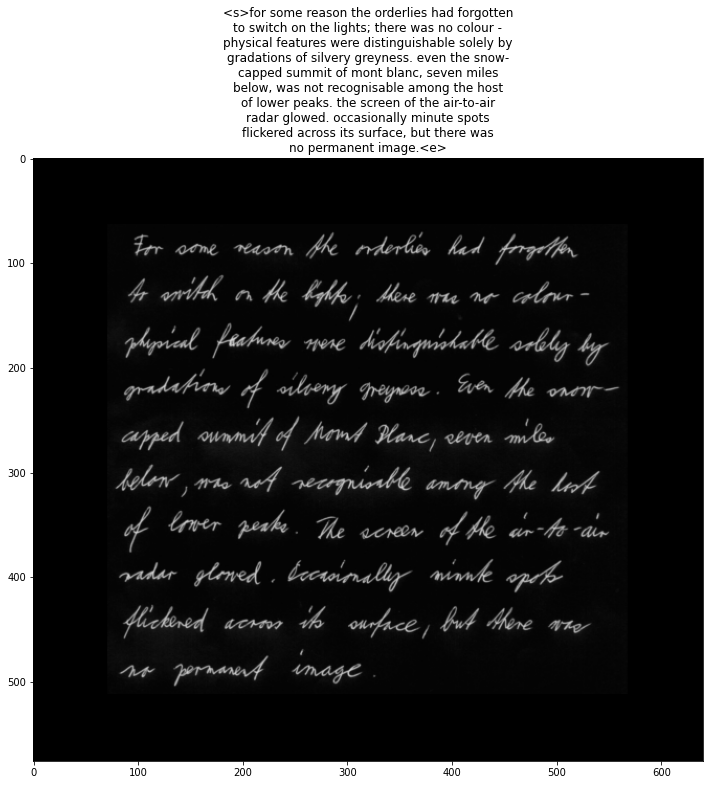

In [44]:
# Testing
dataset = datamodule.data_test
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))